In [2]:
# DEPENDENCIES
import glob, math, json, glob, re
#from shutil import copyfile
import numpy as np
import pandas as pd
#from matplotlib import pyplot as plt
#from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator)
#import logomaker
# LOCAL IMPORTS
#from indexing_classes import GPCRDBIndexing
from gain_classes import GainDomain, GainCollection, Anchors, GPS
import sse_func
import matplotlib.pyplot as plt
import template_finder as tf

def calc_identity(aln_matrix):
    # This takes an alignment matrix with shape=(n_columns, n_sequences) and generates counts based on the identity matrix.
    # Returns the highest non "-" residue count as the most conserved residue and its occupancy based on count("-") - n_struc
    n_struc = aln_matrix.shape[0]
    quality = []
    occ = []
    for col in range(aln_matrix.shape[1]):
        chars, count = np.unique(aln_matrix[:,col], return_counts=True)
        dtype = [('aa', 'S1'), ('counts', int)]
        values = np.array(list(zip(chars,count)), dtype=dtype)
        s_values = np.sort(values, order='counts')

        if s_values[-1][0] == b'-':
            q = s_values[-2][1]
        else:
            q = s_values[-1][1]
        x = np.where(chars == '-')[0][0]
        occ.append(n_struc - count[x])
        quality.append(q)
    return quality, occ


In [3]:
valid_seqs = sse_func.read_multi_seq("/home/hildilab/projects/agpcr_nom/app_gain_gain.fa")
quality_file = "/home/hildilab/projects/agpcr_nom/app_gain_gain.mafft.jal"
alignment_file = "/home/hildilab/projects/agpcr_nom/app_gain_gain.mafft.fa"
stride_files = glob.glob("/home/hildilab/projects/agpcr_nom/sigmas/sigma_2/*")
# This only contains the sigma files for truncated (?) PDBs.
#quality = sse_func.read_quality(quality_file)
gps_minus_one = 6781 
aln_cutoff = 6826 
alignment_dict = sse_func.read_alignment(alignment_file, aln_cutoff)
aln_matrix = np.array([list(seq) for seq in alignment_dict.values()])
#print(aln_matrix.shape)
quality, occ = calc_identity(aln_matrix)

precalc_anchors = [ 662, 1194, 1912, 2490, 2848, 3011, 3073, 3260, #H1-H8
            3455, 3607, 3998, 4279, 4850, 5339, #5341 S1-S6, S7 REMOVED!
            5413, 5813, 6337, 6659, 6696, 6765, 6808] #S8-13
precalc_anchor_occupation = [ 4594.,  6539., 11392., 13658.,  8862., 5092.,  3228., 14189., #H1-H8
                      9413., 12760.,  9420., 11201., 12283., 3676.,#  4562. S1-S6, S7 REMOVED!
                     13992., 12575., 13999., 14051., 14353., 9760., 14215.] #S8-13
precalc_anchor_dict = sse_func.make_anchor_dict(precalc_anchors, 3425)


In [4]:
# In addition to the collection, we need the corresponding PDB file.

allpdbs = glob.glob('../all_pdbs/*.pdb')
'''valid_collection = GainCollection(  alignment_file = alignment_file,
                                    aln_cutoff = aln_cutoff,
                                    quality = quality,
                                    gps_index = gps_minus_one,
                                    stride_files = stride_files,
                                    sequence_files=None,
                                    sequences=valid_seqs,
                                    alignment_dict = alignment_dict,
                                    is_truncated = True,
                                    coil_weight=0.00, # TESTING
                                    #domain_threshold=20, # TESTING
                                    stride_outlier_mode=True)
'''#for gain in valid_collection.collection:
#    gain.create_indexing()"""


'valid_collection = GainCollection(  alignment_file = alignment_file,\n                                    aln_cutoff = aln_cutoff,\n                                    quality = quality,\n                                    gps_index = gps_minus_one,\n                                    stride_files = stride_files,\n                                    sequence_files=None,\n                                    sequences=valid_seqs,\n                                    alignment_dict = alignment_dict,\n                                    is_truncated = True,\n                                    coil_weight=0.00, # TESTING\n                                    #domain_threshold=20, # TESTING\n                                    stride_outlier_mode=True)\n'

In [5]:
"""with open("valid_collection.pkl", "wb") as file:
    pd.to_pickle(valid_collection, file)
    print(f'Object successfully saved to valid_collection.pkl')"""

'with open("valid_collection.pkl", "wb") as file:\n    pd.to_pickle(valid_collection, file)\n    print(f\'Object successfully saved to valid_collection.pkl\')'

In [7]:
v_collection = pd.read_pickle("../valid_collection.pkl")


In [12]:
def get_family(name):
    queries = [('AGR..', name, lambda x: x[-1][-2:]), #
                ('ADGR..', name, lambda x: x[-1][-2:]), 
                ('cadher.*receptor.', name.lower(), lambda x: f"C{x[-1][-1]}"),
                ('cels?r.', name.lower(), lambda x: f"C{x[-1][-1]}"), 
                ('latrophilin.*protein-?\d', name.lower(), lambda x: f"L{x[-1][-1]}"),
                ('latrophilin-?\d', name.lower(), lambda x: f"L{x[-1][-1]}"),
                ('GP?R133', name.upper(),lambda x: 'D1'),
                ('GP?R126', name.upper(),lambda x: 'G6'),
                ('GP?R?124', name.upper(),lambda x: 'A2'),
                ('GP?R?125', name.upper(),lambda x: 'A3'),
                ('GP?R112', name.upper(),lambda x: 'G4'),
                ('GP?R116', name.upper(),lambda x: 'F5'),
                ('GP?R144', name.upper(),lambda x: 'D2'),
                ('ag-?.*-?coupled-?receptor-?.-?\d', name.lower(),lambda x: x[-1].replace('-','')[-2:].upper()),
                ('brain-?specific-?angiogenesis-?inhibitor-?\d', name.lower(), lambda x: f"B{x[-1][-1]}"),
                ('emr\d', name.lower(), lambda x: f"E{x[-1][-1]}"),
                ]
    for pattern, searchstring, output in queries:
        match = re.findall(pattern, searchstring)
        if match != []:
            #if output(match) == '': print(name)
            return output(match)
    return 'X'

fam_list = [get_family(gain.name) for gain in v_collection.collection]
name_list = [gain.name for gain in v_collection.collection]
subfam_list = [x[0] for x in fam_list]
print(fam_list)
receptors, counts  = np.unique(fam_list, return_counts=True)
r_list = list(zip(receptors,counts))
print(r_list)
print(receptors)
fam_counts = {}
for prot in fam_list:
    fam = prot[0]
    if fam not in fam_counts.keys():
        fam_counts[fam] = 0
    fam_counts[fam] += 1

print(fam_counts)

['C2', 'C2', 'C2', 'C2', 'C1', 'C1', 'C1', 'C3', 'C3', 'C3', 'C3', 'C3', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C3', 'C1', 'C1', 'C1', 'C3', 'C2', 'C3', 'C1', 'C3', 'C3', 'C3', 'X', 'C1', 'C1', 'C1', 'C1', 'C1', 'C3', 'C3', 'C3', 'C3', 'C3', 'C2', 'C2', 'X', 'X', 'X', 'X', 'X', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'C3', 'X', 'X', 'C3', 'C3', 'C2', 'C2', 'C3', 'C3', 'C3', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C2', 'C3', 'C3', 'C2', 'C1', 'X', 'X', 'C3', 'C3', 'C3', 'C2', 'C3', 'C3', 'C3', 'C3', 'C3', 'C1', 'C1', 'C1', 'C2', 'C1', 'C3', 'C3', 'C3', 'C3', 'C3', 'C1', 'C3', 'C3', 'C1', 'C1', 'C1', 'C3', 'C3', 'C1', 'C3', 'C1', 'C3', 'C1', 'C3', 'C1', 'C3', 'C3', 'C3', 'C1', 'C1', 'C3', 'C3', 'C2', 'C3', 'C3', 'C3', 'C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2', 'C3', 'C2', 'C1', 'C3', 'C2', 'C3', 'C2', 'C1', 'X', 'X', 'C2', 'X', 'X', 'C2', 'C3', 'C1', 'C3', 'C2', 'C1', 'C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C1', 'C3', 'C2', 'C3', 'C3', 'C2', 'C1', 'C1', 'C2', 'C3', 'C3', 'C1',

G1
544
544 400
Written a total of 160000 GESAMT commands to file.
Running set of GESAMT comparisons with 6 threads.
done.
Found 160000 GESAMT files in target folder ../r2_gesamt_sda_adgrg1
(400, 400)
Cluster Intervals of found and sorted clusters:
 [(0, 378), (378, 382), (382, 384), (384, 389), (389, 393), (393, 395), (395, 397), (397, 398), (398, 400)]
Current cluster: 0 with size 378:
	Centroid: 211
	Name:    A0A7L2JDY4-A0A7L2JDY4_CINMU-AGRG1-Cinclus_mexicanus

Current cluster: 1 with size 4:
	Centroid: 379
	Name:    A0A850V3V7-A0A850V3V7_9CORV-AGRG1-Chloropsis_hardwickii.

Current cluster: 2 with size 2:
	Centroid: 382
	Name:    A0A670K429-A0A670K429_PODMU-AGRG1-Podarcis_muralis

Current cluster: 3 with size 5:
	Centroid: 384
	Name:    A0A6P9CAQ4-A0A6P9CAQ4_PANGU-AGRG1-likeisoformX2-Pantherophis_guttatus

Current cluster: 4 with size 4:
	Centroid: 389
	Name:    A0A6P6R9Q5-A0A6P6R9Q5_CARAU-AGRG1-like-Carassius_auratus

Current cluster: 5 with size 2:
	Centroid: 393
	Name:    A0A3B3RG

/home/hildilab/projects/agpcr_nom/repo/template_finder.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=[18,4], facecolor='w')


Done with run E4
E5
155
Created ../r2_gesamt_sda_adgre5
Written a total of 24025 GESAMT commands to file.
Running set of GESAMT comparisons with 6 threads.
done.
Found 24025 GESAMT files in target folder ../r2_gesamt_sda_adgre5
(155, 155)
Cluster Intervals of found and sorted clusters:
 [(0, 51), (51, 104), (104, 106), (106, 120), (120, 121), (121, 148), (148, 149), (149, 150), (150, 155)]
Current cluster: 0 with size 51:
	Centroid: 30
	Name:    A0A5F4D844-A0A5F4D844_CANLF-AGRE5-Canis_lupus_familiaris

Current cluster: 1 with size 53:
	Centroid: 93
	Name:    A0A5F8AQJ6-A0A5F8AQJ6_MACMU-AGRE5-Macaca_mulatta

Current cluster: 2 with size 2:
	Centroid: 104
	Name:    A0A3B3V5G8-A0A3B3V5G8_9TELE-AGRE5b,duplicate3-Poecilia_latipinna

Current cluster: 3 with size 14:
	Centroid: 107
	Name:    A0A3P9JNU2-A0A3P9JNU2_ORYLA-AGRE5b,duplicate3-Oryzias_latipes

Current cluster: 4 with size 1:
	Centroid: 120
	Name:    A0A2K5XJG5-A0A2K5XJG5_MANLE-AGRE5-Mandrillus_leucophaeus

Current cluster: 5 with si

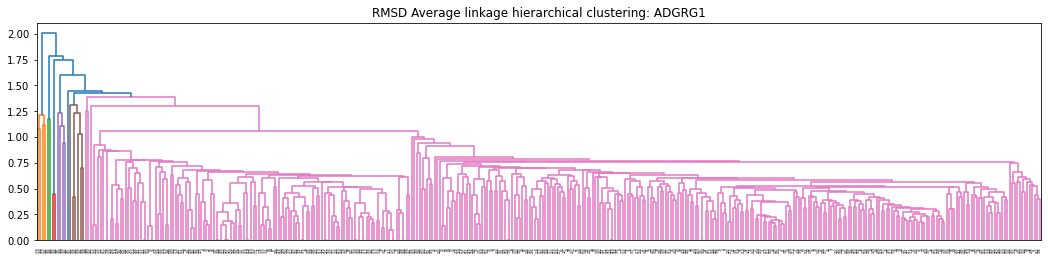

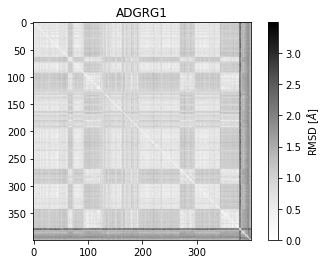

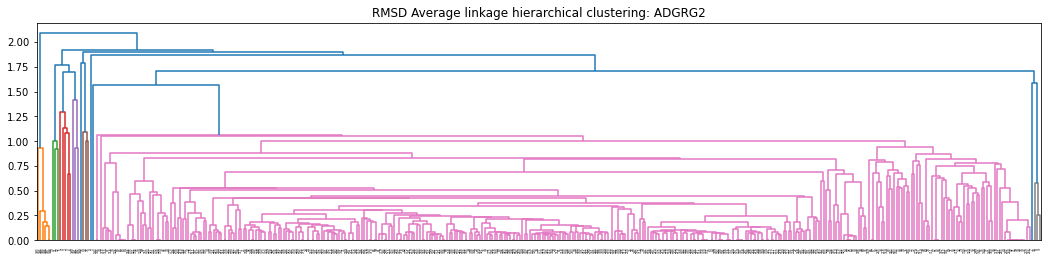

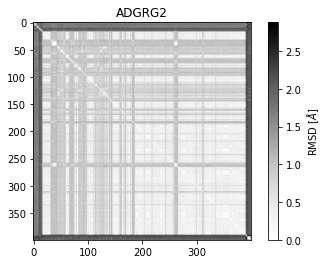

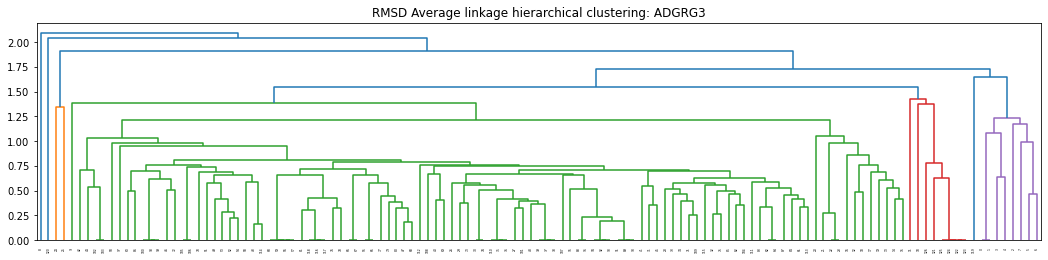

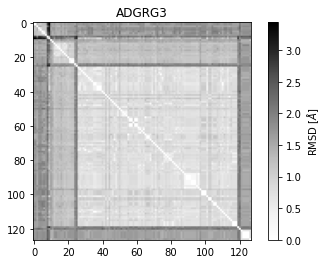

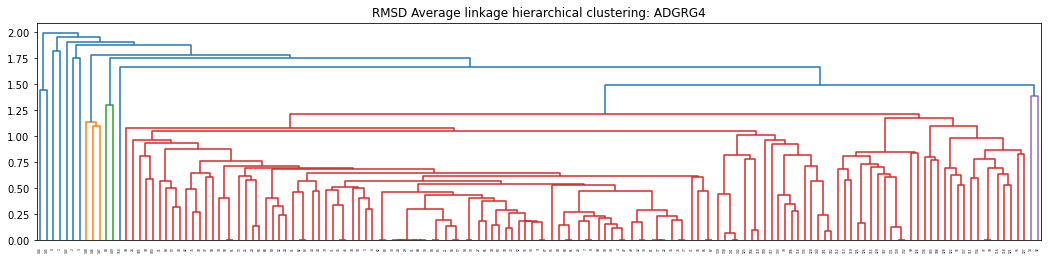

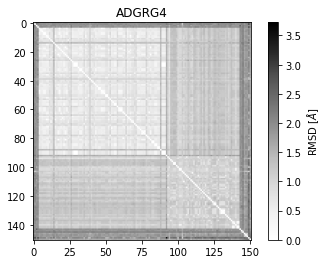

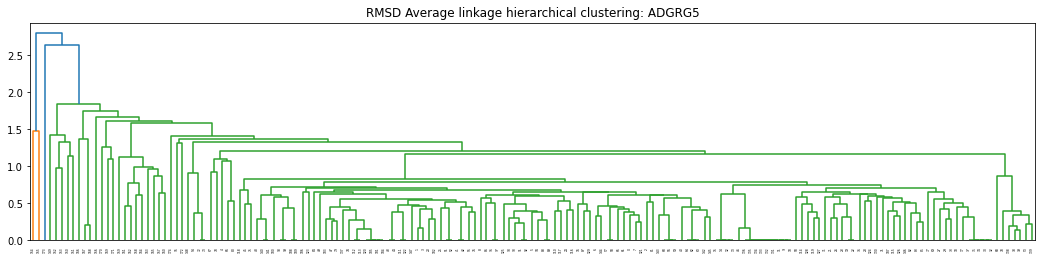

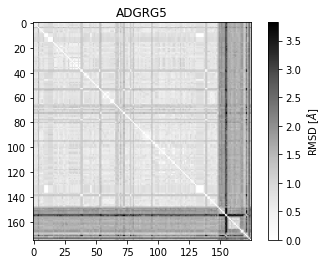

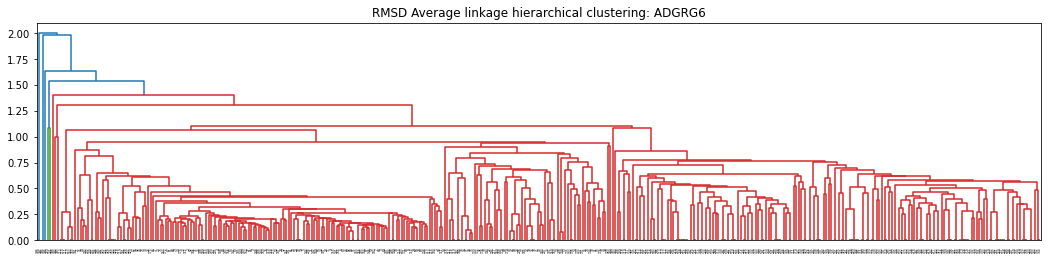

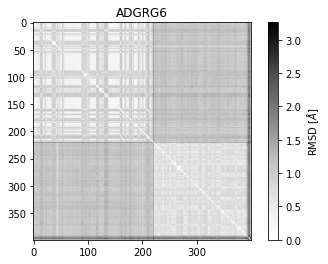

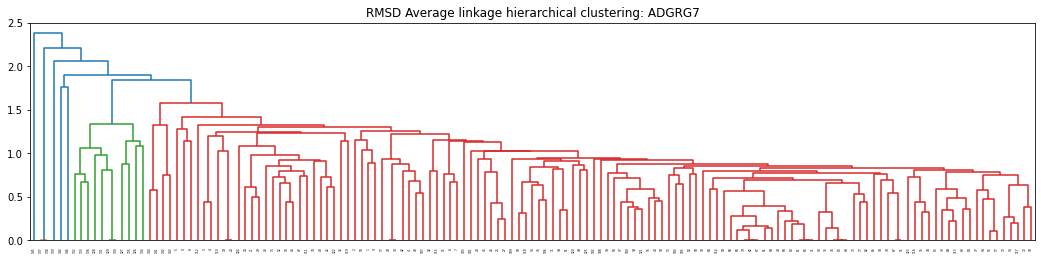

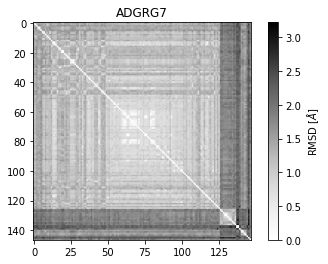

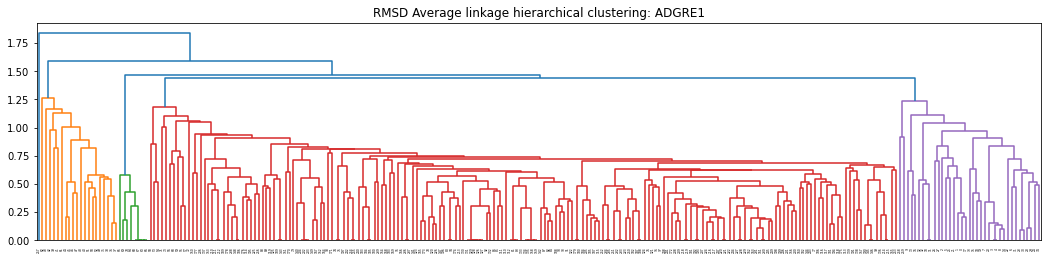

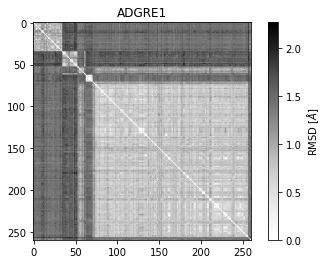

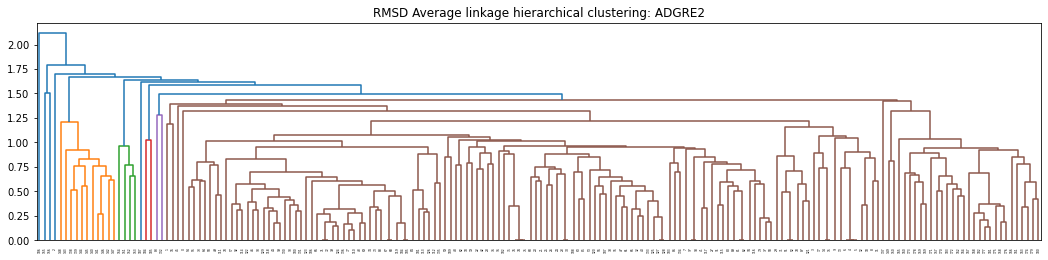

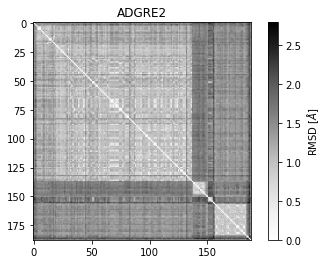

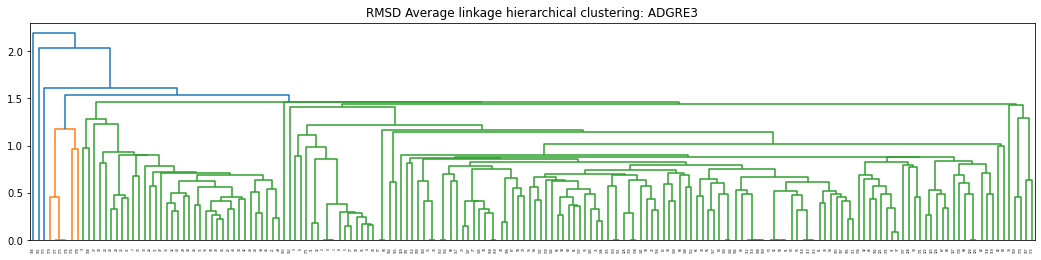

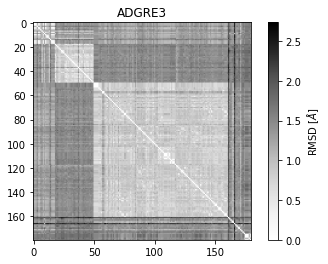

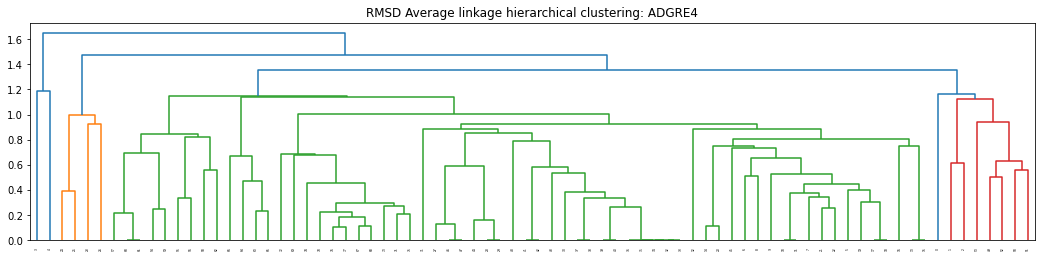

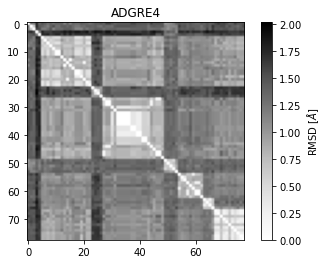

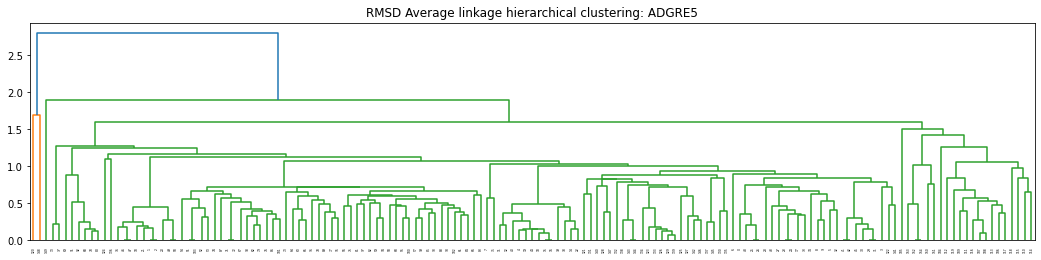

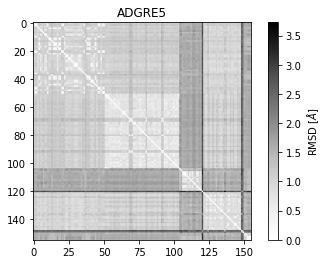

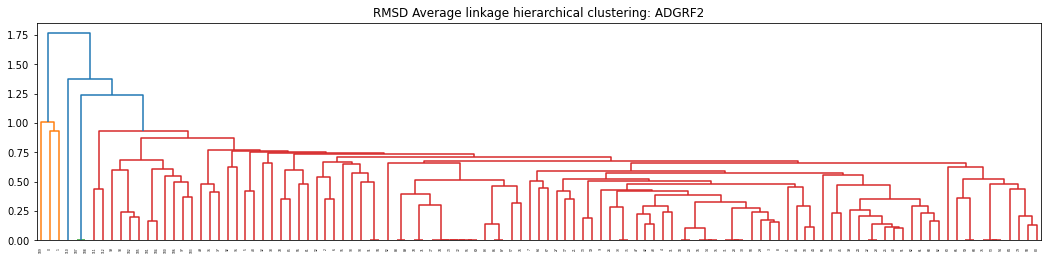

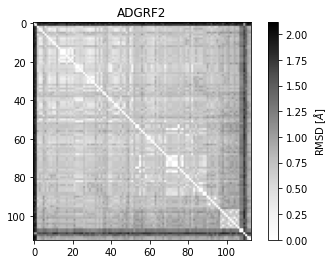

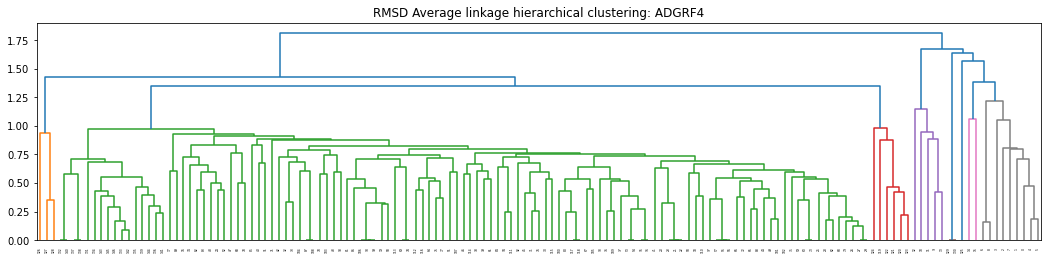

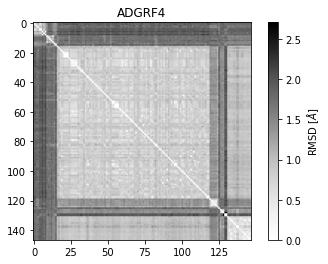

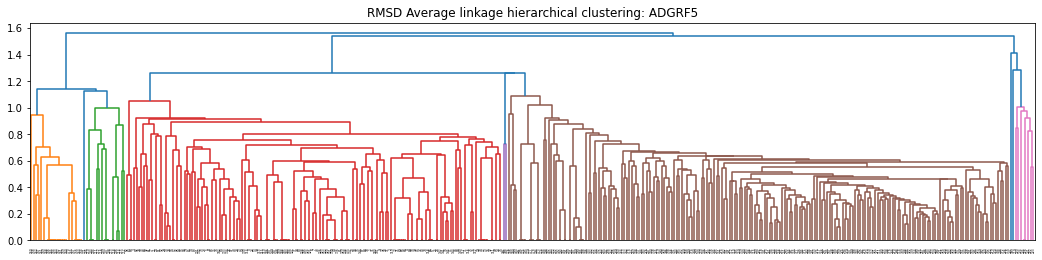

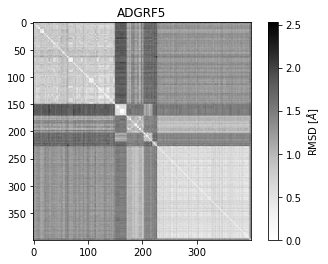

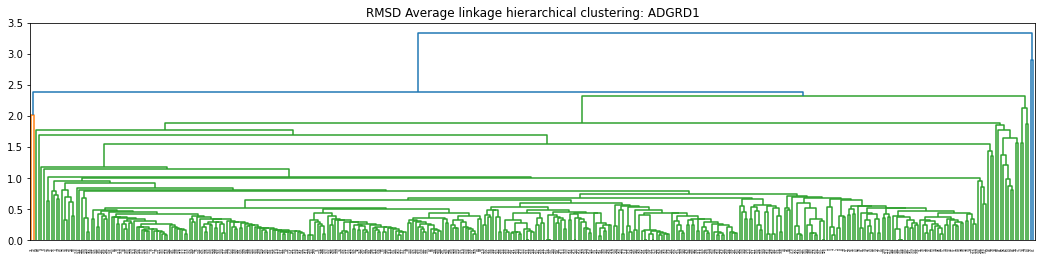

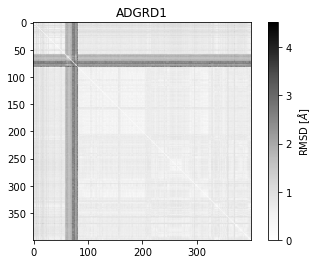

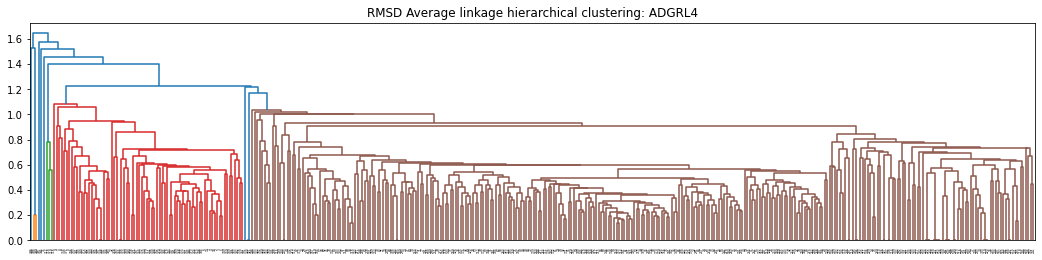

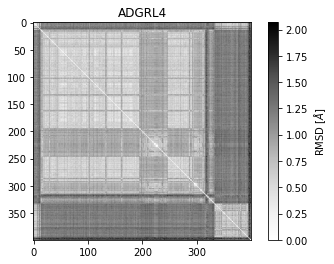

In [13]:
best_structures = {}
best_clusters = {}

manual_receptors = ["G1", "G2", "G3", "G4", "G5", "G6", "G7", "E1", "E2", "E3", "E4", "E5", "F2", "F4", "F5", "D1", "L4"]

for r in manual_receptors:#'ABCDEFGLVX': #enumerate(receptors[:1])
    print(r)
    gain_subset = [ gain for i, gain in enumerate(v_collection.collection) if fam_list[i]==r ]#fam_list[i] == r]#
    print(len(gain_subset))
    gain_idx_list = [ i for i,gain in enumerate(fam_list) if gain == r ] # fam_list
    maxlen = 400
    data_length = len(gain_subset)
    if data_length > maxlen:
        data_length = maxlen # data_length will be used.
        stride = data_length // maxlen
        gain_subset = gain_subset[::stride]
        gain_subset = gain_subset[:maxlen]
        print(len(gain_idx_list), len(gain_subset))

    gesamt_outfolder = f"../r2_gesamt_sda_adgr{r.lower()}"
    
    tf.run_gesamt_execution(gain_subset, outfolder=gesamt_outfolder, pdb_folder='../all_pdbs', domain='sdb', n_threads=6, max_struc=maxlen, no_run=True)
    distances = tf.evaluate_gesamt_files(gesamt_outfolder, n_prot=data_length, penalty_value=6.0, remove=False)
    print(distances.shape)
    results = tf.cluster_agglomerative(distances, gain_subset, n_cluster=9)
    tf.plot_heirarchy(results['reordered_distances'], groupname=f'ADGR{r}', savename=f'r2:ADGR{r}_heirarchy.png')
    tf.plot_matrix(results['reordered_distances'], title=f'ADGR{r}', savename=f'r2_ADGR{r}_ordered_matrix.png')
    #print(results.keys())
    #print(results['overall_best_gain'], results['cluster_best_gains'])
    all_best = gain_subset[results['overall_best_gain']].name
    best_list = []
    for i, c in results['cluster_best_gains']:
        best_list.append((gain_subset[i].name, c, results['cluster_sizes'][c]))
    best_structures[r] = all_best
    best_clusters[r] = best_list
    print("Done with run",r)

In [14]:
#best_structures = {}
#best_clusters = {}
print(best_structures)
print(best_clusters)


{'G1': 'A0A7L3GD10-A0A7L3GD10_9AVES-AGRG1-Anhinga_rufa', 'G2': 'A0A2K5MG19-A0A2K5MG19_CERAT-AGRG2-Cercocebus_atys', 'G3': 'A0A3Q7QGV6-A0A3Q7QGV6_CALUR-AGRG3-likeisoformX3-Callorhinus_ursinus', 'G4': 'A0A2I4CCH8-A0A2I4CCH8_9TELE-AGRG4-like-Austrofundulus_limnaeus.', 'G5': 'A0A6J3IBI5-A0A6J3IBI5_SAPAP-AGRG5-Sapajus_apella', 'G6': 'A0A6P7HB06-A0A6P7HB06_9TELE-AGRG6isoformX6-Parambassis_ranga', 'G7': 'A0A2K5Y1I7-A0A2K5Y1I7_MANLE-AGRG7-Mandrillus_leucophaeus', 'E1': 'A0A2I2YJG7-A0A2I2YJG7_GORGO-AGRE1-Gorilla_gorilla_gorilla', 'E2': 'A0A2Y9QG39-A0A2Y9QG39_TRIMA-AGRE2isoformX3-Trichechus_manatus_latirostris', 'E3': 'A0A2Y9M464-A0A2Y9M464_DELLE-AGRE3isoformX1-Delphinapterus_leucas', 'E4': 'A0A6J3FRL0-A0A6J3FRL0_SAPAP-putativeAGRE4PisoformX1-Sapajus_apella', 'E5': 'G1TKX5-G1TKX5_RABIT-AGRE5-Oryctolagus_cuniculus', 'F2': 'A0A452SUX4-A0A452SUX4_URSAM-AGRF2-Ursus_americanus', 'F4': 'W5PQ70-W5PQ70_SHEEP-AGRF4-Ovis_aries', 'F5': 'A0A7L3N0A5-A0A7L3N0A5_9AVES-AGRF5protein-Oreotrochilus_melanogaster.',

NameError: name 'schwabbel' is not defined

In [15]:
import os,shutil
"""best_sda = {'A':'A0A6G1Q0B9-A0A6G1Q0B9_9TELE-AGRA2-Channa_argus', 
            REMOVE'B':'A0A3Q2EII6-A0A3Q2EII6_CYPVA-AGRB3-Cyprinodon_variegatus', 
            'C':'A0A6J2Q002-A0A6J2Q002_COTGO-cadherinEGFLAGseven-passG-typereceptor3-Cottoperca_gobio',
            'D':'A0A3B4GU56-A0A3B4GU56_9CICH-AGRD1-Pundamilia_nyererei.',
            REMOVE'E':'A0A452F289-A0A452F289_CAPHI-AGRE2-Capra_hircus',
            'F':'A0A3Q2GWY2-A0A3Q2GWY2_HORSE-AGRF5-Equus_caballus',
            REMOVE'G':'A0A7K4YYI3-A0A7K4YYI3_BUCAB-AGRG6protein-Bucorvus_abyssinicus',
            'L':'A0A452HCU9-A0A452HCU9_9SAUR-AGRL3-Gopherus_agassizii',
            'V':'A0A2R9B651-A0A2R9B651_PANPA-AGRV1-Pan_paniscus',
            'X':'A0A674N8V9-A0A674N8V9_TAKRU-Uncharacterizedprotein-Takifugu_rubripes',
            }"""

best_sda = {
'A':'A0A6G1Q0B9-A0A6G1Q0B9_9TELE-AGRA2-Channa_argus', 
'C':'A0A6J2Q002-A0A6J2Q002_COTGO-cadherinEGFLAGseven-passG-typereceptor3-Cottoperca_gobio',
'D':'A0A3B4GU56-A0A3B4GU56_9CICH-AGRD1-Pundamilia_nyererei.',
'F':'A0A3Q2GWY2-A0A3Q2GWY2_HORSE-AGRF5-Equus_caballus',
'L':'A0A452HCU9-A0A452HCU9_9SAUR-AGRL3-Gopherus_agassizii',
'V':'A0A2R9B651-A0A2R9B651_PANPA-AGRV1-Pan_paniscus',
'G1': 'A0A7L3GD10-A0A7L3GD10_9AVES-AGRG1-Anhinga_rufa', 
'G2': 'A0A2K5MG19-A0A2K5MG19_CERAT-AGRG2-Cercocebus_atys', 
'G3': 'A0A3Q7QGV6-A0A3Q7QGV6_CALUR-AGRG3-likeisoformX3-Callorhinus_ursinus', 
'G4': 'A0A2I4CCH8-A0A2I4CCH8_9TELE-AGRG4-like-Austrofundulus_limnaeus.', 
'G5': 'A0A6J3IBI5-A0A6J3IBI5_SAPAP-AGRG5-Sapajus_apella', 
'G6': 'A0A6P7HB06-A0A6P7HB06_9TELE-AGRG6isoformX6-Parambassis_ranga', #('F6QI92-F6QI92_CALJA-AGRG6-Callithrix_jacchus', 0, 220), ('A0A7J7WUN2-A0A7J7WUN2_MYOMY-AGRG6-Myotis_myotis', 2, 170
'G7': 'A0A2K5Y1I7-A0A2K5Y1I7_MANLE-AGRG7-Mandrillus_leucophaeus', 
'E1': 'A0A2I2YJG7-A0A2I2YJG7_GORGO-AGRE1-Gorilla_gorilla_gorilla', #('A0A337S7C5-A0A337S7C5_FELCA-AGRE1-Felis_catus', 6, 181)
'E2': 'A0A2Y9QG39-A0A2Y9QG39_TRIMA-AGRE2isoformX3-Trichechus_manatus_latirostris', 
'E3': 'A0A2Y9M464-A0A2Y9M464_DELLE-AGRE3isoformX1-Delphinapterus_leucas', 
'E4': 'A0A6J3FRL0-A0A6J3FRL0_SAPAP-putativeAGRE4PisoformX1-Sapajus_apella', 
'E5': 'G1TKX5-G1TKX5_RABIT-AGRE5-Oryctolagus_cuniculus', #('A0A2R9CT02-A0A2R9CT02_PANPA-AGRE5-Pan_paniscus', 0, 51), ('F6PLI2-F6PLI2_CANLF-AGRE5-Canis_lupus_familiaris', 1, 53), 
'F2': 'A0A452SUX4-A0A452SUX4_URSAM-AGRF2-Ursus_americanus', #('A0A3Q0CU45-A0A3Q0CU45_MESAU-AGRF2-Mesocricetus_auratus', 1, 50), ('E2RAG2-E2RAG2_CANLF-AGRF2-Canis_lupus_familiaris', 2, 38)
'F4': 'W5PQ70-W5PQ70_SHEEP-AGRF4-Ovis_aries', 
'F5': 'A0A7L3N0A5-A0A7L3N0A5_9AVES-AGRF5protein-Oreotrochilus_melanogaster.', #('A0A1U7SCS2-A0A1U7SCS2_ALLSI-AGRF5isoformX1-Alligator_sinensis', 0, 150), ('A0A7K5GSD3-A0A7K5GSD3_9AVES-AGRF5protein-Chunga_burmeisteri', 6, 169)
'D1': 'A0A369SLT5-A0A369SLT5_9METZ-AGRD1-Trichoplax_sp._H2.', 
'L4': 'A0A7L3KTA8-A0A7L3KTA8_9PASS-AGRL4protein-Drymodes_brunneopygia.'
}
#
# os.mkdir('../sda_templates/')
for f,p in best_sda.items():
    ident = p.split("-")[0]
    pdb = [x for x in allpdbs if ident in x][0]
    shutil.copyfile(pdb, f'../r2_sda_templates/ADGR{f}_sda_{pdb.split("/")[-1]}')


In [20]:
# copy other template files here

import glob,shutil
"""x = [('A0A3B4GU56-A0A3B4GU56_9CICH-AGRD1-Pundamilia_nyererei.', 0, 177), 
 ('A0A1A7WJQ6-A0A1A7WJQ6_9TELE-GR144-Iconisemion_striatum.', 1, 129), 
 ('A0A7L0CLC9-A0A7L0CLC9_9CHAR-AGRD1protein-Rostratula_benghalensis', 2, 9), 
 ('A0A7L0TLM7-A0A7L0TLM7_CHOAC-AGRD1protein-Chordeiles_acutipennis', 3, 7), 
 ('A0A7L1IR52-A0A7L1IR52_SMUAF-AGRD1protein-Smutsornis_africanus', 4, 2), 
 ('A0A7L1LVU1-A0A7L1LVU1_BOMGA-AGRD1protein-Bombycilla_garrulus', 5, 26), 
 ('A0A6I9KUM2-A0A6I9KUM2_PERMB-AGRD1-Peromyscus_maniculatus_bairdii', 6, 26), 
 ('U6CWC5-U6CWC5_NEOVI-ProbableGR133-Neovison_vison', 7, 14), 
 ('A0A7J8GUE4-A0A7J8GUE4_ROUAE-AGRD1-Rousettus_aegyptiacus', 8, 10)]"""
x = [
    ('A0A1U7SCS2-A0A1U7SCS2_ALLSI-AGRF5isoformX1-Alligator_sinensis', 0, 150), 
    ('A0A7K5GSD3-A0A7K5GSD3_9AVES-AGRF5protein-Chunga_burmeisteri', 6, 169),
    ('A0A3Q0CU45-A0A3Q0CU45_MESAU-AGRF2-Mesocricetus_auratus', 1, 50), 
    ('E2RAG2-E2RAG2_CANLF-AGRF2-Canis_lupus_familiaris', 2, 38),
    ('A0A2R9CT02-A0A2R9CT02_PANPA-AGRE5-Pan_paniscus', 0, 51), 
    ('F6PLI2-F6PLI2_CANLF-AGRE5-Canis_lupus_familiaris', 1, 53), 
    ('A0A337S7C5-A0A337S7C5_FELCA-AGRE1-Felis_catus', 6, 181),
    ('F6QI92-F6QI92_CALJA-AGRG6-Callithrix_jacchus', 0, 220),
    ('A0A7J7WUN2-A0A7J7WUN2_MYOMY-AGRG6-Myotis_myotis', 2, 170)
    ]

allpdbs = glob.glob('../all_pdbs/*.pdb')
for i,t in enumerate(x): 
    ident = t[0].split("-")[0]
    pdb = [x for x in allpdbs if ident in x][0]
    shutil.copyfile(pdb, f'../r2_sda_templates/SEC_sda_{pdb.split("/")[-1]}_{t[0].split("AGR")[1][:2]}.pdb')

In [ ]:
y = {'A': 'A0A2Y9F628-A0A2Y9F628_PHYMC-AGRA3isoformX1-Physeter_macrocephalus', 
'B': 'A0A4W6DVA0-A0A4W6DVA0_LATCA-AGRB1b-Lates_calcarifer', 
'C': 'A0A7K6E127-A0A7K6E127_9PASS-CELR3protein-Grantiella_picta.', 
'D': 'I3M3G4-I3M3G4_ICTTR-AGRD1-Ictidomys_tridecemlineatus', 
'E': 'A0A3P8S994-A0A3P8S994_AMPPE-AGRE5b,duplicate2-Amphiprion_percula', 
'F': 'A0A452IH20-A0A452IH20_9SAUR-AGRF5-Gopherus_agassizii', 
'G': 'A0A7K5TKG3-A0A7K5TKG3_9FRIN-AGRG6protein-Urocynchramus_pylzowi.', 
'L': 'A0A452HCU9-A0A452HCU9_9SAUR-AGRL3-Gopherus_agassizii', 
'X': "A0A6F9A857-A0A6F9A857_9TELE-Uncharacterizedprotein-Coregonus_sp._'balchen'.", 
'V': 'A0A6Q2XYK2-A0A6Q2XYK2_ESOLU-AGRV1-Esox_lucius'}

#os.mkdir("../sdb_templates")
for f,a in y.items():
    print(f,a)
    ident = a.split("-")[0]
    pdb = [x for x in allpdbs if ident in x][0]
    print(ident, pdb)
    shutil.copyfile(pdb, f'../sdb_templates/{f}_sdb_{pdb.split("/")[-1]}')

In [ ]:
#print(results.keys())
#print(results['overall_best_gain'], results['cluster_best_gains'])
all_best = gain_subset[results['overall_best_gain']].name
best_list = []
for i, c in results['cluster_best_gains']:
    best_list.append((gain_subset[i].name, c, results['cluster_sizes'][c]))
print(all_best)
print(best_list)